In [1]:
import jax
print(f"JAX devices: {jax.devices()}")
print(f"Backend: {jax.default_backend()}")
assert jax.default_backend() == "gpu", "gpu not detected!"


JAX devices: [CudaDevice(id=0)]
Backend: gpu


In [2]:
from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "gpu")

import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import jax
import os

import jaxley as jx
import jaxley.optimize.transforms as jt
from jaxley.channels import Na, K, Leak
from jaxley.synapses import IonotropicSynapse
from jaxley.connect import connect

In [20]:
n_post_comp = 15
num_pre = 8
post_idx = num_pre          # post cell index inside the network
Nsyn = num_pre

i_delay = 3.0    # ms
i_amp = 0.05   # nA
i_dur = 2.0    # ms
dt = 0.025  # ms
t_max = 50.0   # ms

base_amp = i_amp

syn_post_comp_indices = np.linspace(0, n_post_comp - 1, num_pre).astype(int)
# [0, 2, 4, 6, 8, 10, 12, 14]

def build_net():
    _comp_pre = jx.Compartment()
    _branch_pre = jx.Branch(_comp_pre, ncomp=1)
    _cell_pre = jx.Cell(_branch_pre, parents=np.asarray([-1]))

    _comp_post = jx.Compartment()
    _branch_post = jx.Branch(_comp_post, ncomp=n_post_comp)
    _cell_post = jx.Cell(_branch_post, parents=np.asarray([-1]))

    _cells = [_cell_pre for _ in range(num_pre)] + [_cell_post]
    _net = jx.Network(_cells)

    _net.insert(Na())
    _net.insert(K())
    _net.insert(Leak())

    _syn = IonotropicSynapse()
    for pre_i, comp_i in zip(range(num_pre), syn_post_comp_indices):
        connect(
            _net.cell(pre_i).branch(0).comp(0),
            _net.cell(post_idx).branch(0).comp(int(comp_i)),
            _syn,
        )
    return _net

def setup_recordings(net_obj):
    net_obj.delete_recordings()
    net_obj.cell(post_idx).branch(0).comp(0).record()          # syn 0 = soma
    for ci in syn_post_comp_indices:
        if int(ci) != 0:
            net_obj.cell(post_idx).branch(0).comp(int(ci)).record()
    return net_obj

net_analysis = build_net()
net_analysis = setup_recordings(net_analysis)
net_analysis.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")
print(f"Network: {net_analysis.nodes.shape[0]} compartments, "
      f"{net_analysis.edges.shape[0]} edges")
print(f"Nsyn = {Nsyn}, syn_post_comp_indices = {syn_post_comp_indices}")



Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Added 1 recordings. See `.recordings` for details.
Number of newly added trainable parameters: 8. Total number of trainable parameters: 8
Network: 23 compartments, 8 edges
Nsyn = 8, syn_post_comp_indices = [ 0  2  4  6  8 10 12 14]


In [21]:
params_true = net_analysis.get_parameters()

In [26]:
def simulate_analysis(params_phys, pattern):
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur,
        i_amp=amps, delta_t=dt, t_max=t_max,
    )
    net_analysis.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_analysis.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(
        net_analysis, params=params_phys,
        data_stimuli=data_stimuli, delta_t=dt,
    )
    return traces                         # (Nsyn, T)

def loss_and_traces(params_phys, pattern, target):
    raw_traces = simulate_analysis(params_phys, pattern)
    soma_pred  = raw_traces[0]
    loss = jnp.mean((soma_pred - target) ** 2)
    return loss, raw_traces

_vg_fn = jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True)

def single_trial(params_phys, pattern, target):
    (loss, raw_traces), grads = _vg_fn(params_phys, pattern, target)
    grad_w = grads[0]["IonotropicSynapse_gS"]       # (Nsyn,)
    return grad_w, raw_traces, loss

# batched over patterns (shared params)
batched_vg = jit(jax.vmap(
    jax.value_and_grad(loss_and_traces, argnums=0, has_aux=True),
    in_axes=(None, 0, 0),
))

# patterns_onehot = jnp.eye(Nsyn, dtype=jnp.float64)

# targets_onehot = []
# for p in range(Nsyn):
#     soma = simulate_analysis(params_true, patterns_onehot[p])[0]  # soma trace
#     targets_onehot.append(soma)
# targets_onehot = jnp.stack(targets_onehot, axis=0)

def simulate_soma(params_phys, pattern):
    return simulate_analysis(params_phys, pattern)[0]   # (T,)

batched_simulate_soma = jit(vmap(simulate_soma, in_axes=(None, 0)))
# def simulate_soma_batch(params_phys, patterns):
#     somas = []
#     for p in range(patterns.shape[0]):
#         somas.append(simulate_analysis(params_phys, patterns[p])[0])
#     return jnp.stack(somas, axis=0)  # (P, T)

# targets_onehot = simulate_soma_batch(params_true, patterns_onehot)


In [27]:
gS_true = params_true[0]["IonotropicSynapse_gS"]
params_true = [{"IonotropicSynapse_gS": gS_true}]
transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])
opt_params_true = transform.inverse(params_true)
key_learn = jax.random.PRNGKey(1)
# noise_scale = 0.5

# def add_noise_to_opt_params(opt_params, key, scale):
#     leaves, treedef = jax.tree_util.tree_flatten(opt_params)
#     subkeys = jax.random.split(key, len(leaves))
#     noisy_leaves = [
#         p + scale * jax.random.normal(k, p.shape)
#         for p, k in zip(leaves, subkeys)
#     ]
#     return jax.tree_util.tree_unflatten(treedef, noisy_leaves)

# opt_params_learn = add_noise_to_opt_params(opt_params_true, key_learn, noise_scale)
# params_analysis = transform.forward(opt_params_learn)
key_learn = jax.random.PRNGKey(1)
sigma = 0.05  # 5% lognormal perturbation
gS_learned = jnp.clip(
    gS_true * jnp.exp(sigma * jax.random.normal(key_learn, (Nsyn,))),
    1e-5, 1e-2
)
params_analysis = [{"IonotropicSynapse_gS": gS_learned}]
gS_learned = params_analysis[0]["IonotropicSynapse_gS"]

print("gS_true:", gS_true)
print("gS_learned:", gS_learned)
print(f"max |diff|: {float(jnp.max(jnp.abs(gS_true - gS_learned))):.2e}")

patterns_onehot = jnp.eye(Nsyn, dtype=jnp.float64)   # (8, 8)
print(f"\npatterns_onehot shape: {patterns_onehot.shape}")
print(patterns_onehot)

targets_onehot = batched_simulate_soma(params_true, patterns_onehot)   # (8, T)
T = targets_onehot.shape[1]
t_arr = np.arange(T) * dt                                              # time axis

print(f"\ntargets_onehot shape: {targets_onehot.shape}")
print(f"T = {T},  dt = {dt} ms,  t_max = {t_max} ms")


gS_true: [0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001 0.0001]
gS_learned: [9.42504843e-05 9.94208316e-05 1.00867190e-04 1.04902940e-04
 9.59207643e-05 1.03514370e-04 1.00377964e-04 9.62495051e-05]
max |diff|: 5.75e-06

patterns_onehot shape: (8, 8)
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]

targets_onehot shape: (8, 2002)
T = 2002,  dt = 0.025 ms,  t_max = 50.0 ms


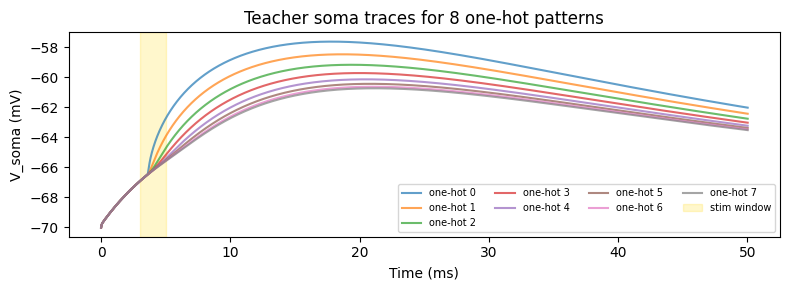

In [25]:
fig, ax = plt.subplots(figsize=(8, 3))
for p in range(Nsyn):
    ax.plot(t_arr, targets_onehot[p], alpha=0.7, label=f"one-hot {p}")
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.2, label="stim window")
ax.set_xlabel("Time (ms)"); ax.set_ylabel("V_soma (mV)")
ax.set_title("Teacher soma traces for 8 one-hot patterns")
ax.legend(fontsize=7, ncol=4)
plt.tight_layout(); plt.show()

In [ ]:
def generate_perturbations(params_base, M, sigma, seed=0):
    gS_base = params_base[0]["IonotropicSynapse_gS"]          # (Nsyn,)
    key = jax.random.PRNGKey(seed)
    eta = jax.random.normal(key, shape=(M, Nsyn))   
    lo, hi = 1e-5, 1e-2
    gS_all = jnp.clip(gS_base[None, :] * jnp.exp(sigma * eta), lo, hi) #  (M, Nsyn)

    params_list = [
        [{"IonotropicSynapse_gS": gS_all[m]}] for m in range(M)
    ]
    return params_list, gS_all

M = 500 

params_s005, gS_s005 = generate_perturbations(params_analysis, M, sigma=0.05, seed=42)
params_s010, gS_s010 = generate_perturbations(params_analysis, M, sigma=0.10, seed=42)

print(f"Generated {M} perturbations for σ=0.05 and σ=0.10")
print(f"\nσ=0.05 gS range: [{float(gS_s005.min()):.6e}, {float(gS_s005.max()):.6e}]")
print(f"σ=0.10 gS range: [{float(gS_s010.min()):.6e}, {float(gS_s010.max()):.6e}]")
print(f"\nAll positive?  σ=0.05: {bool((gS_s005 > 0).all())}   "
      f"σ=0.10: {bool((gS_s010 > 0).all())}")
print(f"Any NaN? σ=0.05: {bool(jnp.isnan(gS_s005).any())}   "
      f"σ=0.10: {bool(jnp.isnan(gS_s010).any())}")


Generated 500 perturbations for σ=0.05 and σ=0.10

σ=0.05  gS range: [4.899679e-05, 2.446266e-04]
σ=0.10  gS range: [4.334379e-05, 2.866354e-04]

All positive?  σ=0.05: True   σ=0.10: True
Any NaN?       σ=0.05: False   σ=0.10: False


In [14]:
# check perturbations
p_test  = 0                                   # one-hot pattern index
pat_ex  = patterns_onehot[p_test]
tgt_ex  = targets_onehot[p_test]
n_check = 5

grads_ck, V_ck = [], []

# baseline (unperturbed)
gw0, tr0, lo0 = single_trial(params_analysis, pat_ex, tgt_ex)
grads_ck.append(np.asarray(gw0));  V_ck.append(np.asarray(tr0))

# a few perturbations (sigma=0.10)
for m in range(n_check):
    gw_m, tr_m, _ = single_trial(params_s010[m], pat_ex, tgt_ex)
    grads_ck.append(np.asarray(gw_m));  V_ck.append(np.asarray(tr_m))

grads_ck = np.stack(grads_ck)          # (n_check+1, Nsyn)
V_ck = np.stack(V_ck)              # (n_check+1, Nsyn, T)

print("Gradient std across perturbations (per synapse):")
print(f"std = {grads_ck.std(axis=0)}")
print(f"nonzero std for every synapse? {bool((grads_ck.std(axis=0) > 0).all())}")

print(f"\nVoltage max-std over time (per recording site):")
for j in range(Nsyn):
    print(f"  site {j}: max std = {V_ck[:, j, :].std(axis=0).max():.4f} mV")

print(f"\nParameters valid?  all gS > 0: {bool((gS_s010 > 0).all())}  "
      f"no NaN: {bool(~jnp.isnan(gS_s010).any())}")
print("\n✓ Perturbations produce non-trivial variation in grads and voltages")


Gradient std across perturbations (per synapse):
  std = [164126.41963512  31410.56131535  28322.17367173  25229.03277514
  22499.36422132  20435.18817375  19237.89001671  18721.57778502]
  nonzero std for every synapse? True

Voltage max-std over time (per recording site):
  site 0: max std = 0.8875 mV
  site 1: max std = 0.7840 mV
  site 2: max std = 0.6787 mV
  site 3: max std = 0.5868 mV
  site 4: max std = 0.5248 mV
  site 5: max std = 0.4858 mV
  site 6: max std = 0.4528 mV
  site 7: max std = 0.4363 mV

Parameters valid?  all gS > 0: True  no NaN: True

✓ Perturbations produce non-trivial variation in grads and voltages


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# Part B1 — Dataset generation loop  (M perturbations × 8 one-hots)
# ══════════════════════════════════════════════════════════════════════
# Primary condition: σ = 0.10
sigma_primary   = 0.10
params_ensemble = params_s010
M_run           = M                   # 200
n_patterns      = Nsyn                # 8 one-hot patterns

# Pre-allocate  ──  shapes follow the spec
GRADS_ens = np.zeros((M_run, n_patterns, Nsyn))          # (M, 8, Nsyn)
VALL_ens  = np.zeros((M_run, n_patterns, Nsyn, T))       # (M, 8, Nsyn, T)
LOSS_ens  = np.zeros((M_run, n_patterns))                # (M, 8)

print(f"Running {M_run} perturbations × {n_patterns} patterns "
      f"= {M_run * n_patterns} trials  (σ={sigma_primary}) ...")
print(f"GRADS  {GRADS_ens.shape}   VALL  {VALL_ens.shape}   LOSS  {LOSS_ens.shape}")

import time as _time
_t0 = _time.time()

for m in range(M_run):
    if m % 25 == 0:
        elapsed = _time.time() - _t0
        print(f"  m={m:4d}/{M_run}  ({elapsed:.1f}s)")

    ((losses_m, traces_m), grads_m) = batched_vg(
        params_ensemble[m], patterns_onehot, targets_onehot,
    )
    # grads_m is a tree with same structure as params; extract gS
    GRADS_ens[m] = np.asarray(grads_m[0]["IonotropicSynapse_gS"])   # (8, Nsyn)
    VALL_ens[m]  = np.asarray(traces_m)                              # (8, Nsyn, T)
    LOSS_ens[m]  = np.asarray(losses_m)                              # (8,)

elapsed = _time.time() - _t0
print(f"\nDone in {elapsed:.1f}s  ({elapsed / M_run:.2f}s per perturbation)")
print(f"GRADS  {GRADS_ens.shape}   VALL  {VALL_ens.shape}   LOSS  {LOSS_ens.shape}")
print(f"LOSS range: [{LOSS_ens.min():.2f}, {LOSS_ens.max():.2f}]")


Running 500 perturbations × 8 patterns = 4000 trials  (σ=0.1) ...
GRADS  (500, 8, 8)   VALL  (500, 8, 8, 2002)   LOSS  (500, 8)
  m=   0/500  (0.0s)
  m=  25/500  (31.3s)
  m=  50/500  (50.0s)
  m=  75/500  (68.7s)
  m= 100/500  (87.4s)
  m= 125/500  (106.1s)
  m= 150/500  (124.8s)
  m= 175/500  (143.5s)
  m= 200/500  (162.2s)
  m= 225/500  (180.9s)
  m= 250/500  (199.6s)
  m= 275/500  (218.4s)
  m= 300/500  (237.1s)
  m= 325/500  (255.8s)
  m= 350/500  (274.5s)
  m= 375/500  (293.2s)
  m= 400/500  (311.9s)
  m= 425/500  (330.6s)
  m= 450/500  (349.4s)
  m= 475/500  (368.1s)

Done in 386.8s  (0.77s per perturbation)
GRADS  (500, 8, 8)   VALL  (500, 8, 8, 2002)   LOSS  (500, 8)
LOSS range: [0.01, 164.15]

Saved → /n/home12/isanchez/jaxneuro/outputs/perturbation_onehot_dataset.npz  (512.8 MB)


ALIGNMENT REPORT

For each one-hot pattern p, which gradient component has the largest mean |grad| across the 500-member ensemble?

 Pattern p           Bit vector   argmax |grad|  |grad| at p   Match?
------------------------------------------------------------------------
         0             10000000               0     1.31e+06        ✓
         1             01000000               1     1.39e+05        ✓
         2             00100000               2     1.94e+04        ✓
         3             00010000               3     1.72e+04        ✓
         4             00001000               4     7.74e+04        ✓
         5             00000100               5     5.82e+05        ✓
         6             00000010               6     4.24e+04        ✓
         7             00000001               7     1.78e+04        ✓

Dominant gradient matches one-hot index: 8/8


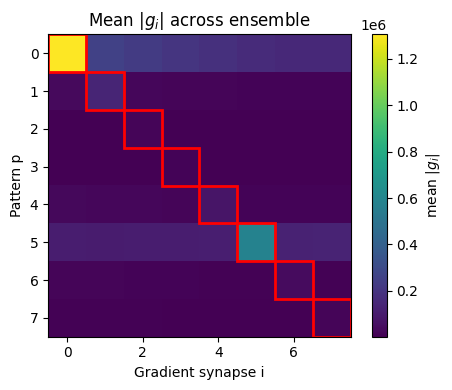

In [16]:
# ══════════════════════════════════════════════════════════════════════
# Part B2 — Alignment report
# ══════════════════════════════════════════════════════════════════════
print("=" * 72)
print("ALIGNMENT REPORT")
print("=" * 72)
print(f"\nFor each one-hot pattern p, which gradient component has the "
      f"largest mean |grad| across the {M_run}-member ensemble?\n")
print(f"{'Pattern p':>10} {'Bit vector':>20} {'argmax |grad|':>15} "
      f"{'|grad| at p':>12} {'Match?':>8}")
print("-" * 72)

n_match = 0
for p in range(Nsyn):
    mean_abs_grad = np.mean(np.abs(GRADS_ens[:, p, :]), axis=0)   # (Nsyn,)
    dominant_idx  = int(np.argmax(mean_abs_grad))
    match         = dominant_idx == p
    n_match      += int(match)
    bits = "".join(np.asarray(patterns_onehot[p]).astype(int).astype(str))
    print(f"{p:>10} {bits:>20} {dominant_idx:>15} "
          f"{mean_abs_grad[p]:>12.2e} {'✓' if match else '✗':>8}")

print(f"\nDominant gradient matches one-hot index: {n_match}/{Nsyn}")

# Also show full mean |grad| matrix (patterns × synapses)
mean_abs_G = np.mean(np.abs(GRADS_ens), axis=0)   # (8, 8)
fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(mean_abs_G, cmap="viridis")
ax.set_xlabel("Gradient synapse i"); ax.set_ylabel("Pattern p")
ax.set_title(r"Mean $|g_i|$ across ensemble")
for p in range(Nsyn):
    ax.add_patch(plt.Rectangle((p - 0.5, p - 0.5), 1, 1,
                                fill=False, ec="red", lw=2))
plt.colorbar(im, ax=ax, label=r"mean $|g_i|$")
plt.tight_layout(); plt.show()

print("=" * 72)


In [17]:
# ══════════════════════════════════════════════════════════════════════
# Part C — Feature extraction  (ΔV, AUC, VMAX, SLOPE)
# ══════════════════════════════════════════════════════════════════════

# ── C0: Window definitions ──
tail_ms = 20.0                                  # ms of post-stimulus tail
W_start = i_delay                               # stimulus + tail start
W_end   = i_delay + i_dur + tail_ms             # stimulus + tail end
B_start = 0.0                                   # baseline start
B_end   = i_delay                               # baseline end

W_mask = (t_arr >= W_start) & (t_arr <= W_end)  # stimulus+tail window
B_mask = (t_arr >= B_start) & (t_arr <  B_end)  # pre-stim baseline

print(f"Stimulus+tail window W: [{W_start:.1f}, {W_end:.1f}] ms  "
      f"→ {W_mask.sum()} timepoints")
print(f"Baseline window B:      [{B_start:.1f}, {B_end:.1f}) ms  "
      f"→ {B_mask.sum()} timepoints")

# ── C1: Baseline-subtracted voltage ──
# ΔV(m,p,j,t) = V(m,p,j,t) − mean_{t∈B} V(m,p,j,t)
V_baseline = VALL_ens[:, :, :, B_mask].mean(axis=3, keepdims=True)  # (M,8,Nsyn,1)
DV = VALL_ens - V_baseline                                          # (M,8,Nsyn,T)

print(f"\nΔV shape: {DV.shape}   ({DV.nbytes / 1e6:.1f} MB)")

# ── C2: Scalar features per (m, p, j) computed over window W ──
DV_W = DV[:, :, :, W_mask]                         # (M, 8, Nsyn, |W|)

# 1) AUC  (positive only)
AUC = np.maximum(DV_W, 0).sum(axis=3) * dt         # (M, 8, Nsyn)

# 2) Max depolarisation
VMAX = DV_W.max(axis=3)                             # (M, 8, Nsyn)

# 3) Peak slope  (finite-diff dV/dt, then max in W)
dVdt_full   = np.diff(DV, axis=3) / dt              # (M, 8, Nsyn, T-1)
W_slope_mask = W_mask[:-1]                           # T-1 boolean for diff'd axis
SLOPE = dVdt_full[:, :, :, W_slope_mask].max(axis=3) # (M, 8, Nsyn)

print(f"AUC   shape: {AUC.shape}")
print(f"VMAX  shape: {VMAX.shape}")
print(f"SLOPE shape: {SLOPE.shape}")

# ── C3: Time-resolved ΔV kept in DV (full T) for Part D1 ──
print(f"\nFull ΔV retained for time-resolved analysis  "
      f"({DV.nbytes / 1e6:.1f} MB)")


Stimulus+tail window W: [3.0, 25.0] ms  → 881 timepoints
Baseline window B:      [0.0, 3.0) ms  → 120 timepoints

ΔV shape: (500, 8, 8, 2002)   (512.5 MB)
AUC   shape: (500, 8, 8)
VMAX  shape: (500, 8, 8)
SLOPE shape: (500, 8, 8)

Full ΔV retained for time-resolved analysis  (512.5 MB)


R_time shape: (8, 8, 8, 2002)  (p, i, j, T)


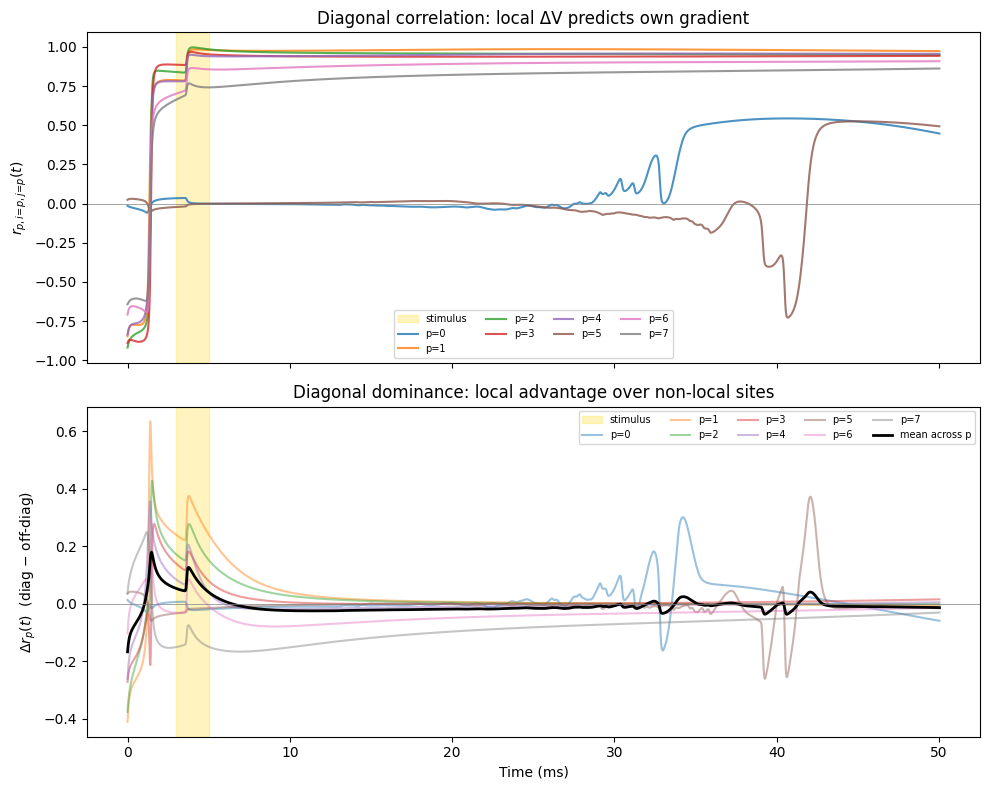

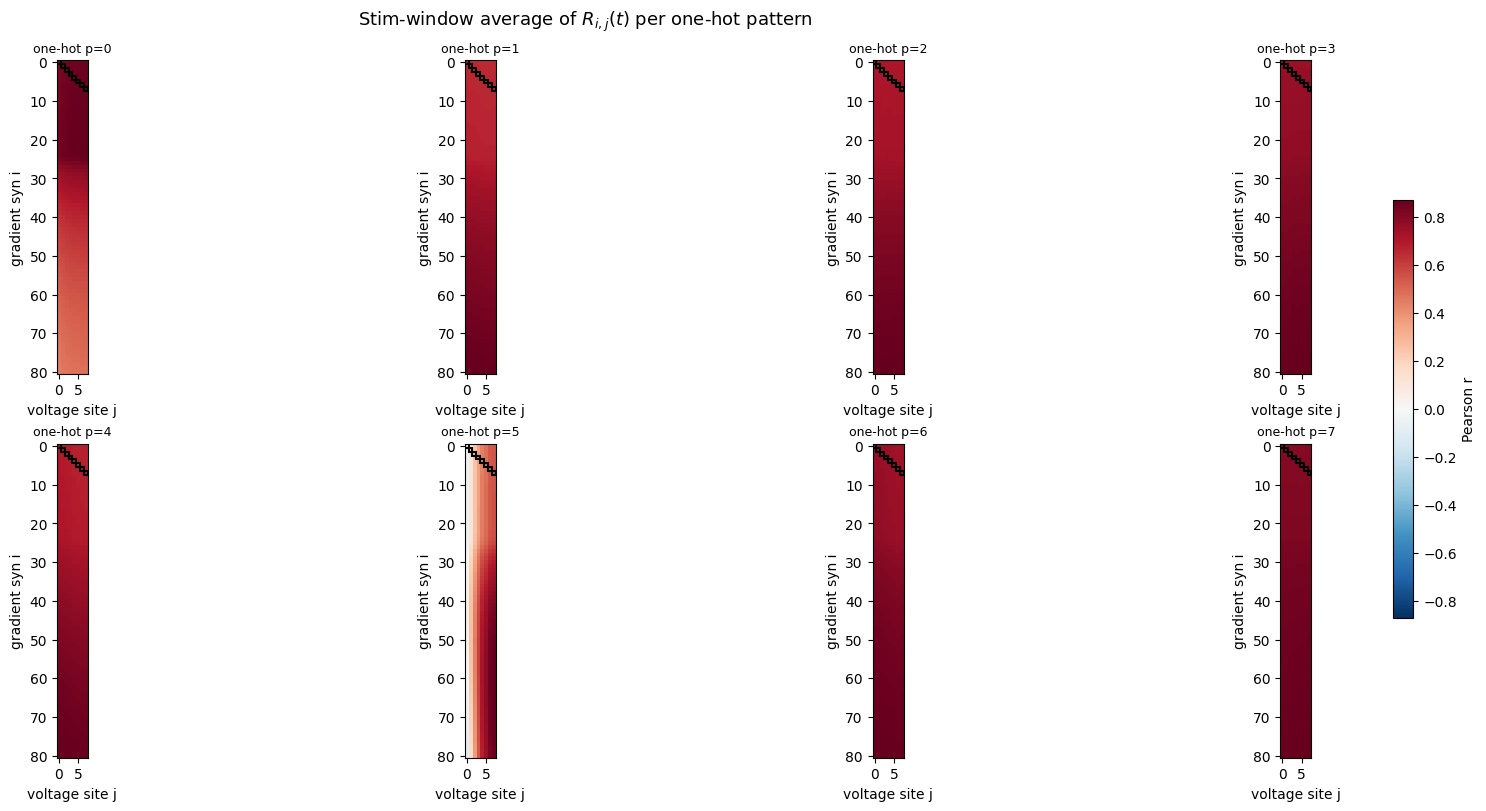

In [18]:
# ══════════════════════════════════════════════════════════════════════
# Part D1 — Time-resolved correlation curves
# ══════════════════════════════════════════════════════════════════════
#
# r_{p,i,j}(t) = corr_m( ΔV_{m,p,j}(t),  GRADS_{m,p,i} )
#
# Correlation is across the ensemble index m.
# ──────────────────────────────────────────────────────────────────────

def corr_vs_time(X, y, eps=1e-12):
    """Pearson r between columns of X and scalar y, across rows (axis 0).
    X : (M, T)    y : (M,)    → (T,)
    """
    X_dm = X - X.mean(axis=0, keepdims=True)
    y_dm = y - y.mean()
    num   = (X_dm * y_dm[:, None]).sum(axis=0)              # (T,)
    denom = np.sqrt((X_dm**2).sum(axis=0) * (y_dm**2).sum()) + eps
    return num / denom


# Full tensor: R_time[p, i, j, t]
R_time = np.zeros((Nsyn, Nsyn, Nsyn, T))

for p in range(Nsyn):
    for i in range(Nsyn):
        g_pi = GRADS_ens[:, p, i]                           # (M,)
        for j in range(Nsyn):
            R_time[p, i, j, :] = corr_vs_time(
                DV[:, p, j, :], g_pi
            )

print(f"R_time shape: {R_time.shape}  (p, i, j, T)")

# ─── Plot 1: Diagonal curves  r_{p, i=p, j=p}(t) ───
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

ax = axes[0]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
for p in range(Nsyn):
    ax.plot(t_arr, R_time[p, p, p, :], label=f"p={p}", alpha=0.8)
ax.set_ylabel(r"$r_{p,i\!=\!p,j\!=\!p}(t)$")
ax.set_title("Diagonal correlation: local ΔV predicts own gradient")
ax.legend(fontsize=7, ncol=4)
ax.axhline(0, color="grey", lw=0.5)

# ─── Plot 2: Diagonal dominance  Δr_p(t) ───
# Δr_p(t) = r_{p,i=p,j=p}(t) − mean_{j≠p} r_{p,i=p,j}(t)
delta_r = np.zeros((Nsyn, T))
for p in range(Nsyn):
    r_diag    = R_time[p, p, p, :]
    r_offdiag = np.mean(
        [R_time[p, p, j, :] for j in range(Nsyn) if j != p], axis=0
    )
    delta_r[p] = r_diag - r_offdiag

ax = axes[1]
ax.axvspan(i_delay, i_delay + i_dur, color="gold", alpha=0.25, label="stimulus")
for p in range(Nsyn):
    ax.plot(t_arr, delta_r[p], alpha=0.45, label=f"p={p}")
ax.plot(t_arr, delta_r.mean(axis=0), "k", lw=2, label="mean across p")
ax.set_ylabel(r"$\Delta r_p(t)$  (diag − off-diag)")
ax.set_xlabel("Time (ms)")
ax.set_title("Diagonal dominance: local advantage over non-local sites")
ax.legend(fontsize=7, ncol=5)
ax.axhline(0, color="grey", lw=0.5)

plt.tight_layout()
plt.show()

# ─── Plot 3: Full R_{i,j} heatmap at stim-window average, per pattern ───
fig, axes = plt.subplots(2, 4, figsize=(18, 8), constrained_layout=True)
stim_mask = (t_arr >= i_delay) & (t_arr <= i_delay + i_dur)

for p in range(Nsyn):
    ax  = axes[p // 4, p % 4]
    mat = R_time[p, :, :, stim_mask].mean(axis=2)    # (i, j)  stim-avg
    vmax = max(np.abs(mat).max(), 0.01)
    im = ax.imshow(mat, cmap="RdBu_r", vmin=-vmax, vmax=vmax)
    ax.set_title(f"one-hot p={p}", fontsize=9)
    ax.set_xlabel("voltage site j"); ax.set_ylabel("gradient syn i")
    for d in range(Nsyn):
        ax.add_patch(plt.Rectangle((d-0.5, d-0.5), 1, 1,
                                    fill=False, ec="k", lw=1.5))
plt.colorbar(im, ax=axes.ravel().tolist(), label="Pearson r", shrink=0.6)
fig.suptitle(r"Stim-window average of $R_{i,j}(t)$ per one-hot pattern",
             fontsize=13)
plt.show()


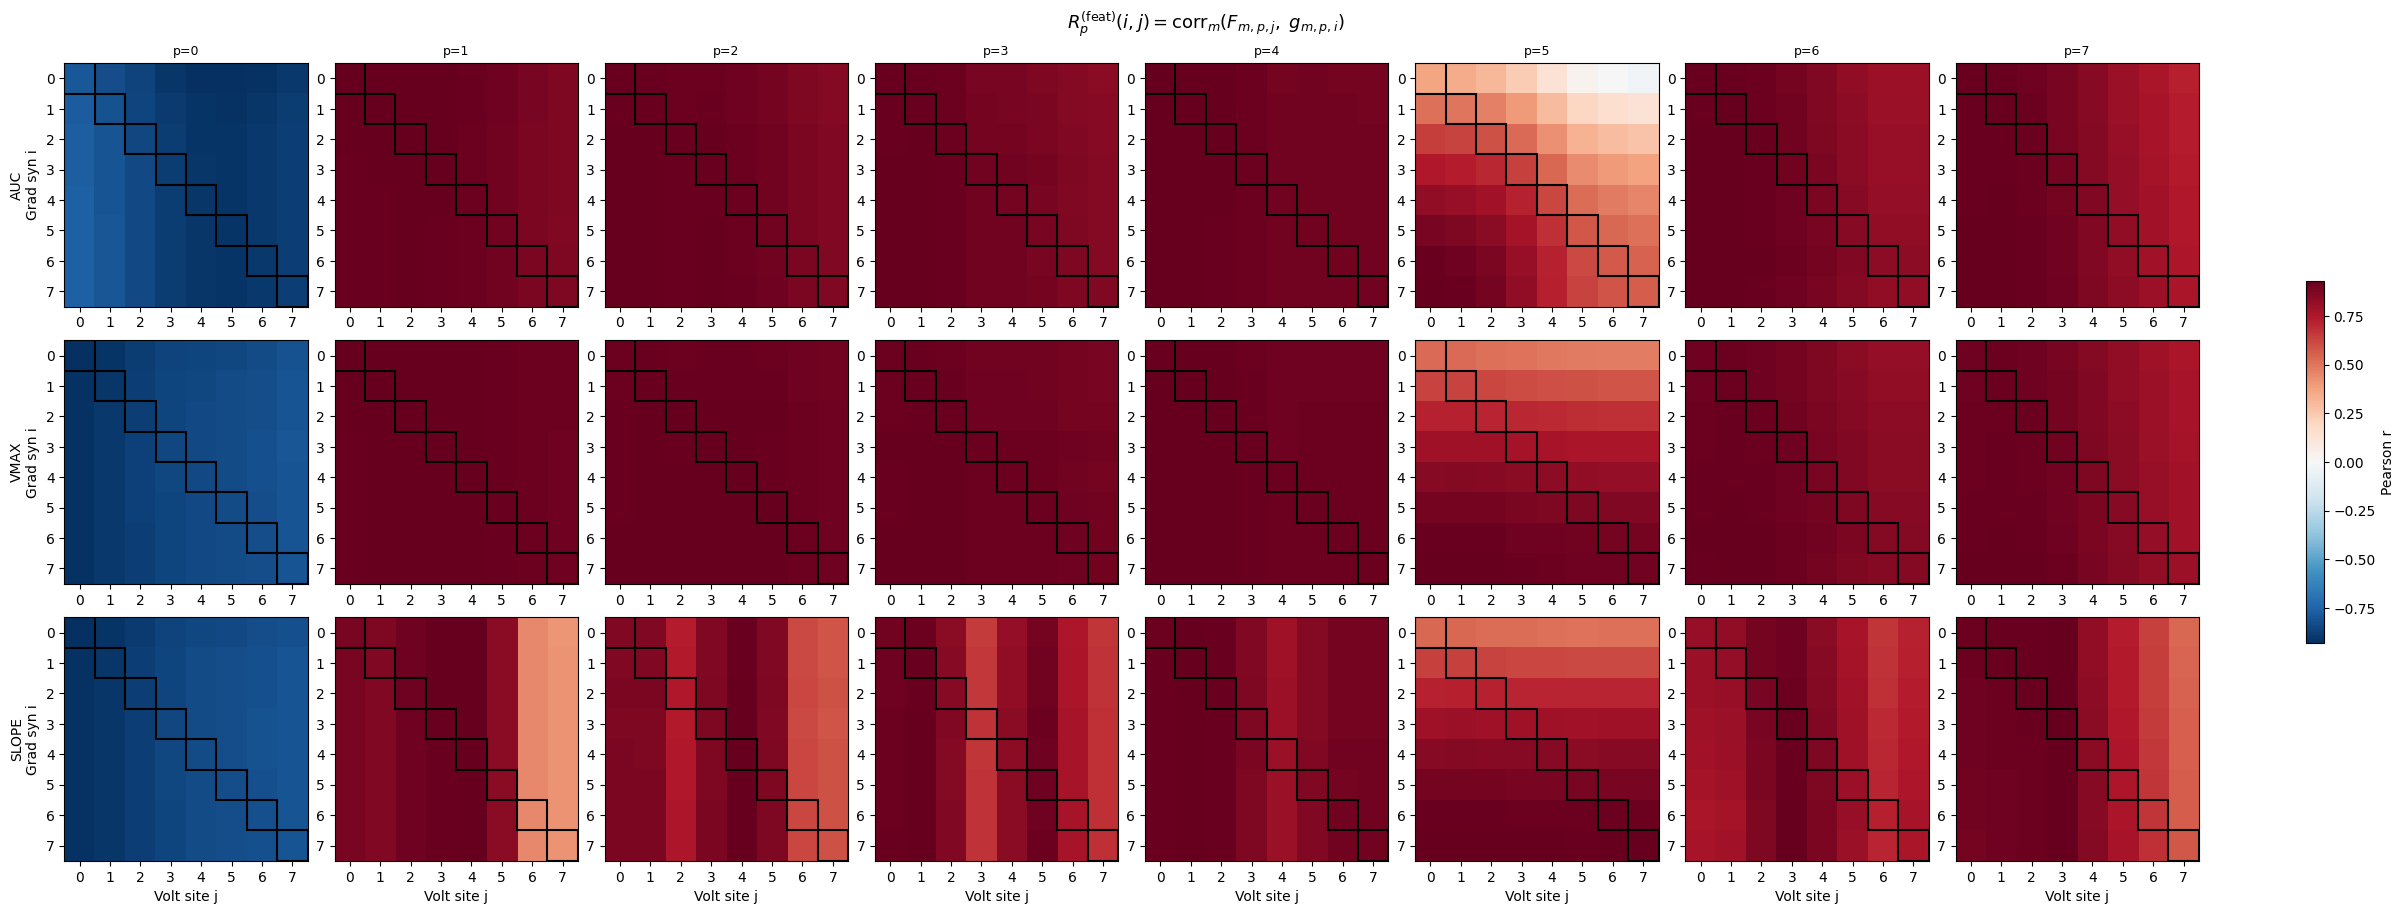

Feature → gradient diagonal dominance summary
 Feature  Pattern  diag_mean  offdiag_mean  diag/offdiag
------------------------------------------------------------
     AUC        0     0.0728        0.0728          1.00
     AUC        1     0.9615        0.9613          1.00
     AUC        2     0.9463        0.9461          1.00
     AUC        3     0.9347        0.9337          1.00
     AUC        4     0.9594        0.9577          1.00
     AUC        5     0.0204        0.0204          1.00
     AUC        6     0.9327        0.9279          1.01
     AUC        7     0.9038        0.9004          1.00
------------------------------------------------------------
    VMAX        0     0.0999        0.0998          1.00
    VMAX        1     0.9771        0.9770          1.00
    VMAX        2     0.9513        0.9514          1.00
    VMAX        3     0.9331        0.9327          1.00
    VMAX        4     0.9570        0.9563          1.00
    VMAX        5     0.0418      

In [19]:
# ══════════════════════════════════════════════════════════════════════
# Part D2 — Feature-to-gradient correlation matrices
# ══════════════════════════════════════════════════════════════════════
#
# For each pattern p and feature F ∈ {AUC, VMAX, SLOPE}:
#   R_p^(F)(i,j) = corr_m( F_{m,p,j},  GRADS_{m,p,i} )
#
# → (Nsyn × Nsyn) matrix per (feature, pattern)
# ──────────────────────────────────────────────────────────────────────

def corr_1d(x, y, eps=1e-12):
    """Pearson r between two 1-D arrays."""
    xd = x - x.mean()
    yd = y - y.mean()
    return float((xd * yd).sum() / (np.sqrt((xd**2).sum() * (yd**2).sum()) + eps))


def feature_grad_matrix(FEAT, GRADS_ens, p):
    """R(i,j) = corr_m(FEAT[m,p,j], GRADS[m,p,i])  → (Nsyn, Nsyn)."""
    R = np.zeros((Nsyn, Nsyn))
    for i in range(Nsyn):
        for j in range(Nsyn):
            R[i, j] = corr_1d(FEAT[:, p, j], GRADS_ens[:, p, i])
    return R


feature_names  = ["AUC", "VMAX", "SLOPE"]
feature_arrays = [AUC, VMAX, SLOPE]

R_feat = {}   # key = (feat_name, p) → (Nsyn, Nsyn)
for fn, fa in zip(feature_names, feature_arrays):
    for p in range(Nsyn):
        R_feat[(fn, p)] = feature_grad_matrix(fa, GRADS_ens, p)

# ─── Heatmaps: 3 features × 8 patterns ───
fig, axes = plt.subplots(3, Nsyn, figsize=(3 * Nsyn, 3 * 3),
                         constrained_layout=True)

for row, fn in enumerate(feature_names):
    for col in range(Nsyn):
        ax  = axes[row, col]
        mat = R_feat[(fn, col)]
        vm  = max(np.abs(mat).max(), 0.01)
        im  = ax.imshow(mat, cmap="RdBu_r", vmin=-vm, vmax=vm)
        for d in range(Nsyn):
            ax.add_patch(plt.Rectangle((d-0.5, d-0.5), 1, 1,
                                        fill=False, ec="k", lw=1.5))
        if row == 0:
            ax.set_title(f"p={col}", fontsize=9)
        if col == 0:
            ax.set_ylabel(f"{fn}\nGrad syn i")
        if row == 2:
            ax.set_xlabel("Volt site j")
        ax.set_xticks(range(Nsyn))
        ax.set_yticks(range(Nsyn))

plt.colorbar(im, ax=axes.ravel().tolist(), label="Pearson r", shrink=0.45)
fig.suptitle(
    r"$R_p^{(\mathrm{feat})}(i,j) = \mathrm{corr}_m(F_{m,p,j},\;g_{m,p,i})$",
    fontsize=13)
plt.show()

# ─── Summary table: diagonal dominance ───
print("=" * 80)
print("Feature → gradient diagonal dominance summary")
print("=" * 80)
print(f"{'Feature':>8} {'Pattern':>8} {'diag_mean':>10} "
      f"{'offdiag_mean':>13} {'diag/offdiag':>13}")
print("-" * 60)

for fn in feature_names:
    for p in range(Nsyn):
        mat = R_feat[(fn, p)]
        diag_vals = np.array([mat[i, i] for i in range(Nsyn)])
        off_mask  = ~np.eye(Nsyn, dtype=bool)
        off_vals  = mat[off_mask]

        diag_mean = np.abs(diag_vals).mean()
        off_mean  = np.abs(off_vals).mean()
        ratio     = diag_mean / (off_mean + 1e-12)

        print(f"{fn:>8} {p:>8} {diag_mean:>10.4f} "
              f"{off_mean:>13.4f} {ratio:>13.2f}")
    print("-" * 60)

# ─── Aggregate across patterns ───
print("\n" + "=" * 80)
print("Aggregate across patterns (mean ± std of per-pattern ratios)")
print("=" * 80)
print(f"{'Feature':>8} {'mean diag/off':>14} {'std':>8}")
print("-" * 35)
for fn in feature_names:
    ratios = []
    for p in range(Nsyn):
        mat = R_feat[(fn, p)]
        diag_m = np.abs(np.diag(mat)).mean()
        off_m  = np.abs(mat[~np.eye(Nsyn, dtype=bool)]).mean()
        ratios.append(diag_m / (off_m + 1e-12))
    ratios = np.array(ratios)
    print(f"{fn:>8} {ratios.mean():>14.2f} {ratios.std():>8.2f}")
print("=" * 80)


# Option A: Retrain-from-scratch ensemble

**Goal:** Estimate whether the gradient–physiology relationship holds across independently trained solutions $\theta^*(s) = \text{Train}(\text{seed}=s)$.

- **A0:** Teacher params + probe set (already defined above: `params_true`, `patterns_onehot`, `targets_onehot`).
- **A1:** Fixed training dataset shared across seeds (A1a).
- **A2:** `train_one_seed()` with fresh init per seed.
- **A3:** Run S seeds, collect learned params.
- **A4:** Evaluate gradients + physiology on the 8 one-hot probes for each seed.
- **A5:** Feature extraction (ΔV, AUC, VMAX, SLOPE).
- **A6:** Pattern-specific correlations across seeds (seed = unit of independence).


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# A1 — Fixed training dataset (shared across all seeds)
# ══════════════════════════════════════════════════════════════════════
import optax
import time as _time

N_train = 256
key_data = jax.random.PRNGKey(0)
patterns_train = jax.random.bernoulli(
    key_data, p=0.5, shape=(N_train, Nsyn)
).astype(jnp.float64)

# Teacher targets for the training set
targets_train = batched_simulate_soma(params_true, patterns_train)  # (N_train, T)

print(f"Training set: {N_train} patterns × {Nsyn} synapses")
print(f"patterns_train shape: {patterns_train.shape}")
print(f"targets_train  shape: {targets_train.shape}")
print(f"All targets finite:   {bool(jnp.isfinite(targets_train).all())}")
print(f"Target V range:       [{float(targets_train.min()):.2f}, "
      f"{float(targets_train.max()):.2f}] mV")


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# A2 — Training infrastructure
# ══════════════════════════════════════════════════════════════════════

# A2.1  Dedicated training net (soma recording only — faster than full analysis net)
net_train = build_net()
net_train.delete_recordings()
net_train.cell(post_idx).branch(0).comp(0).record()           # soma only
net_train.IonotropicSynapse.edge("all").make_trainable("IonotropicSynapse_gS")

train_transform = jx.ParamTransform([
    {"IonotropicSynapse_gS": jt.SigmoidTransform(1e-5, 1e-2)},
])

# ── Simulation / loss (closure over net_train) ──────────────────────
def _sim_soma_train(params_phys, pattern):
    """Forward-simulate one pattern → soma trace (T,)."""
    amps = base_amp * pattern
    currents = jx.datapoint_to_step_currents(
        i_delay=i_delay, i_dur=i_dur, i_amp=amps, delta_t=dt, t_max=t_max,
    )
    net_train.delete_stimuli()
    data_stimuli = None
    for i in range(num_pre):
        data_stimuli = (
            net_train.cell(i).branch(0).loc(0.0)
            .data_stimulate(currents[i], data_stimuli=data_stimuli)
        )
    traces = jx.integrate(
        net_train, params=params_phys,
        data_stimuli=data_stimuli, delta_t=dt,
    )
    return traces[0]                                          # (T,)

_batched_soma_train = vmap(_sim_soma_train, in_axes=(None, 0))

def _train_loss_batch(opt_params, pats, tgts):
    """Mean MSE over a batch of patterns."""
    params_phys = train_transform.forward(opt_params)
    preds = _batched_soma_train(params_phys, pats)            # (B, T)
    return jnp.mean((preds - tgts) ** 2)

# ── Optimizer ────────────────────────────────────────────────────────
train_lr = 5e-3
train_optimizer = optax.adam(train_lr)

@jit
def _train_step(opt_params, opt_state, pats, tgts):
    loss, grads = jax.value_and_grad(_train_loss_batch)(
        opt_params, pats, tgts,
    )
    updates, new_state = train_optimizer.update(grads, opt_state, opt_params)
    new_params = optax.apply_updates(opt_params, updates)
    return new_params, new_state, loss

# ── A2.2-4  Full training function ──────────────────────────────────
def train_one_seed(seed, patterns_train, targets_train,
                   n_steps=500, batch_size=32, log_every=25):
    """Train one seed → (params_learned, train_log)."""
    key = jax.random.PRNGKey(seed)

    # A2.2  Seed-dependent initialisation (near 1e-4, positive)
    key, subkey = jax.random.split(key)
    gS0 = 1e-4 * jnp.exp(0.05 * jax.random.normal(subkey, (Nsyn,)))
    params0 = [{"IonotropicSynapse_gS": gS0}]
    opt_params = train_transform.inverse(params0)
    opt_state = train_optimizer.init(opt_params)

    N = patterns_train.shape[0]
    loss_log = []

    for step in range(n_steps):
        # random minibatch
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(subkey, N, shape=(batch_size,), replace=False)
        pats_b = patterns_train[idx]
        tgts_b = targets_train[idx]

        opt_params, opt_state, loss = _train_step(
            opt_params, opt_state, pats_b, tgts_b,
        )

        if step % log_every == 0 or step == n_steps - 1:
            loss_log.append((step, float(loss)))

    params_learned = train_transform.forward(opt_params)
    return params_learned, {"losses": loss_log, "final_loss": float(loss)}

# ── Sanity check: single seed ───────────────────────────────────────
print("Sanity check: training seed=0 (100 steps) ...")
_t0 = _time.time()
_p0, _log0 = train_one_seed(0, patterns_train, targets_train, n_steps=100)
_t1 = _time.time()
print(f"  Time:        {_t1-_t0:.1f}s")
print(f"  Init loss:   {_log0['losses'][0][1]:.4f}")
print(f"  Final loss:  {_log0['final_loss']:.4f}")
print(f"  gS learned:  {np.asarray(_p0[0]['IonotropicSynapse_gS'])}")
print(f"  All finite:  {all(np.isfinite(l) for _, l in _log0['losses'])}")


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# A3 + A4 — Train S seeds  &  analyse each on the 8 one-hot probes
# ══════════════════════════════════════════════════════════════════════

S = 20                       # start 20 to debug; scale to 50–100 when stable
n_steps_train = 500
batch_size_train = 32

# Pre-allocate  (spec shapes: GRADS[s,p,i], VALL[s,p,j,t], LOSS[s,p])
gS_all_seeds   = np.zeros((S, Nsyn))                         # (S, 8)
GRADS_seeds    = np.zeros((S, Nsyn, Nsyn))                    # (S, 8, 8)
VALL_seeds     = np.zeros((S, Nsyn, Nsyn, T))                 # (S, 8, 8, T)
LOSS_seeds     = np.zeros((S, Nsyn))                          # (S, 8)
train_logs_all = []

print(f"Training {S} seeds × {n_steps_train} steps  "
      f"(batch={batch_size_train}, lr={train_lr})")
print(f"GRADS  {GRADS_seeds.shape}   VALL  {VALL_seeds.shape}   "
      f"LOSS  {LOSS_seeds.shape}\n")

t_start = _time.time()

for s in range(S):
    t_seed = _time.time()

    # ── A3: Train ────────────────────────────────────────────────────
    params_s, log_s = train_one_seed(
        seed=s, patterns_train=patterns_train,
        targets_train=targets_train,
        n_steps=n_steps_train, batch_size=batch_size_train,
    )
    train_logs_all.append(log_s)
    gS_all_seeds[s] = np.asarray(params_s[0]["IonotropicSynapse_gS"])

    # ── A4: Evaluate on 8 one-hot probes (via net_analysis) ─────────
    ((losses_s, traces_s), grads_s) = batched_vg(
        params_s, patterns_onehot, targets_onehot,
    )
    GRADS_seeds[s] = np.asarray(grads_s[0]["IonotropicSynapse_gS"])  # (8,8)
    VALL_seeds[s]  = np.asarray(traces_s)                             # (8,8,T)
    LOSS_seeds[s]  = np.asarray(losses_s)                             # (8,)

    dt_seed = _time.time() - t_seed
    if s % 5 == 0 or s == S - 1:
        print(f"  seed {s:3d}/{S}  train_loss={log_s['final_loss']:.4f}  "
              f"probe_loss_mean={float(LOSS_seeds[s].mean()):.4f}  "
              f"({dt_seed:.1f}s)")

elapsed = _time.time() - t_start
print(f"\nDone: {S} seeds in {elapsed:.1f}s  ({elapsed / S:.1f}s per seed)")
print(f"Train final-loss range: "
      f"[{min(l['final_loss'] for l in train_logs_all):.4f}, "
      f"{max(l['final_loss'] for l in train_logs_all):.4f}]")
print(f"All final losses finite: "
      f"{all(np.isfinite(l['final_loss']) for l in train_logs_all)}")

# ── Training loss curves ────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 4))
for s_i, log_s in enumerate(train_logs_all):
    steps, losses = zip(*log_s["losses"])
    ax.plot(steps, losses, alpha=0.4, lw=0.8)
ax.set_xlabel("Step"); ax.set_ylabel("Training loss (MSE)")
ax.set_title(f"Training curves for {S} seeds")
ax.set_yscale("log")
plt.tight_layout(); plt.show()

# ── Learned gS distribution ────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 3))
for i in range(Nsyn):
    ax.scatter(np.full(S, i) + 0.1 * np.random.randn(S),
               gS_all_seeds[:, i], s=12, alpha=0.6)
ax.axhline(float(gS_true[0]), color="red", ls="--", lw=1, label="gS_true")
ax.set_xlabel("Synapse index"); ax.set_ylabel("Learned gS")
ax.set_title(f"Learned gS across {S} seeds")
ax.legend(); plt.tight_layout(); plt.show()

# ── Save ────────────────────────────────────────────────────────────
save_path_A = os.path.join(save_dir, "retrain_ensemble.npz")
np.savez(
    save_path_A,
    gS_all_seeds=gS_all_seeds,
    GRADS_seeds=GRADS_seeds,
    VALL_seeds=VALL_seeds,
    LOSS_seeds=LOSS_seeds,
    gS_true=np.asarray(gS_true),
    patterns_onehot=np.asarray(patterns_onehot),
    syn_post_comp_indices=syn_post_comp_indices,
    dt=dt, t_max=t_max, i_delay=i_delay, i_dur=i_dur,
    S=S, Nsyn=Nsyn, n_steps=n_steps_train,
)
fsize = os.path.getsize(save_path_A)
print(f"\nSaved → {save_path_A}  ({fsize / 1e6:.1f} MB)")


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# A5 — Feature extraction on retrain ensemble
# ══════════════════════════════════════════════════════════════════════
# Windows (same definitions as Part C)
tail_ms_A  = 20.0
W_start_A  = i_delay
W_end_A    = i_delay + i_dur + tail_ms_A
B_start_A  = 0.0
B_end_A    = i_delay

W_mask_A = (t_arr >= W_start_A) & (t_arr <= W_end_A)
B_mask_A = (t_arr >= B_start_A) & (t_arr <  B_end_A)

print(f"Window W: [{W_start_A:.1f}, {W_end_A:.1f}] ms  -> {W_mask_A.sum()} pts")
print(f"Baseline B: [{B_start_A:.1f}, {B_end_A:.1f}) ms -> {B_mask_A.sum()} pts")

# -- C1: Baseline-subtracted voltage --
V_base_A = VALL_seeds[:, :, :, B_mask_A].mean(axis=3, keepdims=True)  # (S,8,8,1)
DV_A     = VALL_seeds - V_base_A                                       # (S,8,8,T)

# -- C2: Scalar features over window W --
DV_W_A = DV_A[:, :, :, W_mask_A]                              # (S, 8, 8, |W|)

# AUC (positive area only)
AUC_A   = np.maximum(DV_W_A, 0).sum(axis=3) * dt              # (S, 8, 8)

# Max depolarisation
VMAX_A  = DV_W_A.max(axis=3)                                   # (S, 8, 8)

# Peak slope (max dV/dt in W)
dVdt_A         = np.diff(DV_A, axis=3) / dt                    # (S, 8, 8, T-1)
W_slope_mask_A = W_mask_A[:-1]
SLOPE_A        = dVdt_A[:, :, :, W_slope_mask_A].max(axis=3)   # (S, 8, 8)

print(f"\nDV_A    shape: {DV_A.shape}   ({DV_A.nbytes / 1e6:.1f} MB)")
print(f"AUC_A   shape: {AUC_A.shape}")
print(f"VMAX_A  shape: {VMAX_A.shape}")
print(f"SLOPE_A shape: {SLOPE_A.shape}")


In [ ]:
# ══════════════════════════════════════════════════════════════════════
# A6.2 — Feature-to-gradient correlation matrices (across seeds)
# ══════════════════════════════════════════════════════════════════════
# R_p^(feat)(i,j) = corr_s( FEAT_{s,p,j},  GRADS_{s,p,i} )
# ----------------------------------------------------------------------

feature_names_A  = ["AUC", "VMAX", "SLOPE"]
feature_arrays_A = [AUC_A, VMAX_A, SLOPE_A]

R_feat_A = {}   # key = (feat_name, p) -> (Nsyn, Nsyn)
for fn, fa in zip(feature_names_A, feature_arrays_A):
    for p in range(Nsyn):
        R_feat_A[(fn, p)] = feature_grad_matrix(fa, GRADS_seeds, p)

# --- Heatmaps: 3 features x 8 patterns  ------------------------------
fig, axes = plt.subplots(3, Nsyn, figsize=(3 * Nsyn, 9),
                         constrained_layout=True)

for row, fn in enumerate(feature_names_A):
    for col in range(Nsyn):
        ax  = axes[row, col]
        mat = R_feat_A[(fn, col)]
        vm  = max(np.abs(mat).max(), 0.01)
        im  = ax.imshow(mat, cmap="RdBu_r", vmin=-vm, vmax=vm)
        for d in range(Nsyn):
            ax.add_patch(plt.Rectangle((d - 0.5, d - 0.5), 1, 1,
                                        fill=False, ec="k", lw=1.5))
        if row == 0:
            ax.set_title(f"p={col}", fontsize=9)
        if col == 0:
            ax.set_ylabel(f"{fn}\nGrad syn i")
        if row == 2:
            ax.set_xlabel("Volt site j")
        ax.set_xticks(range(Nsyn))
        ax.set_yticks(range(Nsyn))

plt.colorbar(im, ax=axes.ravel().tolist(), label="Pearson r", shrink=0.45)
fig.suptitle(
    f"Retrain ensemble (S={S}): feature -> gradient correlation",
    fontsize=13)
plt.show()

# --- Summary table: diagonal dominance  ------------------------------
print("=" * 80)
print(f"Retrain ensemble (S={S}): Feature -> gradient diagonal dominance")
print("=" * 80)
print(f"{'Feature':>8} {'Pattern':>8} {'diag_mean':>10} "
      f"{'offdiag_mean':>13} {'diag/offdiag':>13}")
print("-" * 60)

for fn in feature_names_A:
    for p in range(Nsyn):
        mat = R_feat_A[(fn, p)]
        diag_m = np.abs(np.diag(mat)).mean()
        off_m  = np.abs(mat[~np.eye(Nsyn, dtype=bool)]).mean()
        ratio  = diag_m / (off_m + 1e-12)
        print(f"{fn:>8} {p:>8} {diag_m:>10.4f} "
              f"{off_m:>13.4f} {ratio:>13.2f}")
    print("-" * 60)

# --- Aggregate across patterns  --------------------------------------
print("\n" + "=" * 80)
print(f"Aggregate across patterns (S={S} seeds)")
print("=" * 80)
print(f"{'Feature':>8} {'mean diag/off':>14} {'std':>8}")
print("-" * 35)
for fn in feature_names_A:
    ratios = []
    for p in range(Nsyn):
        mat = R_feat_A[(fn, p)]
        diag_m = np.abs(np.diag(mat)).mean()
        off_m  = np.abs(mat[~np.eye(Nsyn, dtype=bool)]).mean()
        ratios.append(diag_m / (off_m + 1e-12))
    ratios = np.array(ratios)
    print(f"{fn:>8} {ratios.mean():>14.2f} {ratios.std():>8.2f}")
print("=" * 80)
